### 整体用时间序列分析模型显著但预测效果不好，随着时间推移会有很大误差，预测结果很容易收敛到某一个值附近
### 下面用分而治之的策略，先对各个厂家进行分类，然后剔除能手工预测的厂家，剩下的再整体分析
### type1可以用近期均值预测，剔除；

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import *
def adf_test(ts,rs):
    adftest = adfuller(ts,regression=rs)
    adf_res = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_res['Critical Value (%s)' % key] = value
    return adf_res
def getids(typeid):
    typepath='./figures/'+str(typeid)
    FileNames=os.listdir(typepath)
    ids = [w.replace('.jpg', '') for w in FileNames]
    return ids
def plotuser(user_id):
    p1=p[p['user_id']==user_id]
    p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
    p1s.plot()
    plt.show()
    return p1
def plotacfpacf(dta):
    #dta:numpy.ndarray
    fig = plt.figure(figsize=(12,8))
    ax1=fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
    plt.show()
    
type1ids=getids(1)
p=pd.read_csv('./Tianchi_power.csv',parse_dates=[0],infer_datetime_format=True)

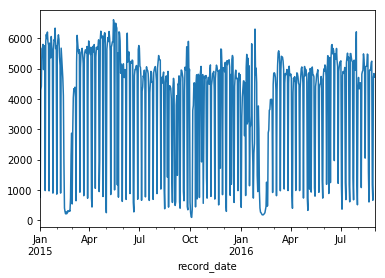

In [2]:
p1=p[p['user_id']==65]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

### 上图有很强的周期性，观察数据可发现，周日休息一天，元旦休息了两天

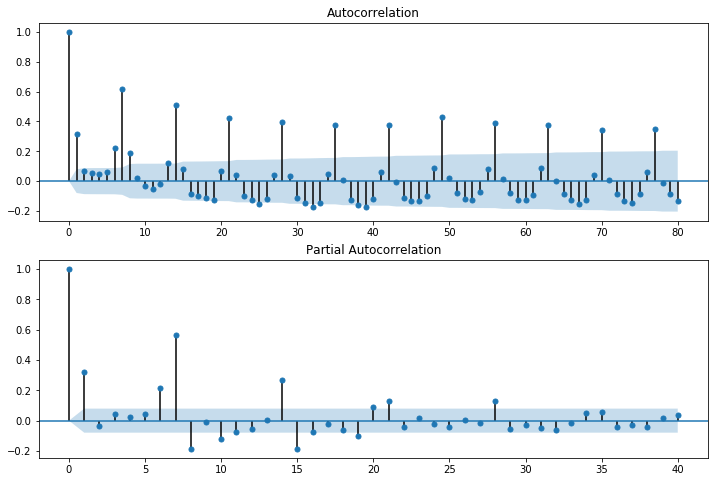

In [5]:
dta=p1.power_consumption.values
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

In [6]:
adf_test(dta,'c')

Test Statistic                  -4.782621
p-value                          0.000059
Lags Used                       19.000000
Number of Observations Used    589.000000
Critical Value (5%)             -2.866460
Critical Value (1%)             -3.441501
Critical Value (10%)            -2.569390
dtype: float64

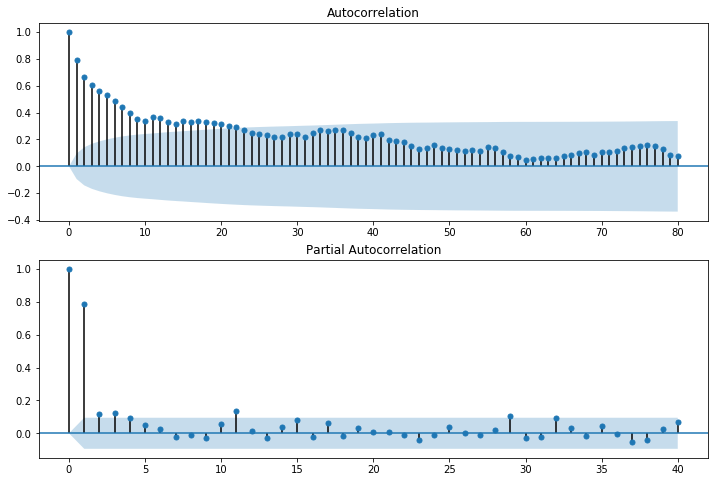

In [10]:
p1a=p1[p1.power_consumption>4000]
dta=p1a.power_consumption.values
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

In [11]:
adf_test(dta,'c')

Test Statistic                  -4.386762
p-value                          0.000313
Lags Used                        3.000000
Number of Observations Used    425.000000
Critical Value (5%)             -2.868365
Critical Value (1%)             -3.445831
Critical Value (10%)            -2.570405
dtype: float64

In [13]:
p1.to_csv('65.csv',index=False,header=False)

### 把分阶段的数据的最近阶段筛选出来，然后计算近期均值，按近期均值进行排序，从大到小开始预测

In [18]:
p1=p[p.record_date>'2016-08-01']

In [20]:
p2all=p1.groupby(['user_id'],as_index=False).sum()

In [22]:
p2all.to_csv('p2all.csv')

In [31]:
p2all=pd.read_csv('p2all.csv',usecols=[1,2,3])

In [32]:
p2all=p2all.reset_index()

In [35]:
for i in range(len(p2all)):
    p1=p[p.user_id==p2all.iloc[i]['user_id']]
    p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
    ax=p1s.plot()
    fig=ax.get_figure()
    fig.savefig('./filter/'+str(i)+' '+str(p2all.iloc[i]['user_id'])+' '
                +str(p2all.iloc[i]['power_consumption'])+'.jpg')
    fig.clear()

In [55]:
p1

,record_date,user_id,power_consumption
862315,2016-08-21,1416,673104
862316,2016-08-22,1416,637631
862317,2016-08-23,1416,610640
862318,2016-08-24,1416,575675
862319,2016-08-25,1416,583203
862320,2016-08-26,1416,572880
862321,2016-08-27,1416,531026
862322,2016-08-28,1416,523621
862323,2016-08-29,1416,538329
862324,2016-08-30,1416,552407


### 排除1416厂家

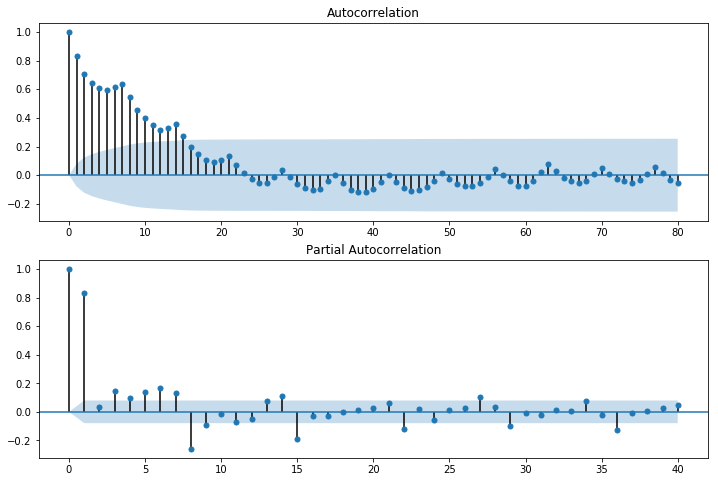

In [43]:
p1=p[p['user_id']<>1416]
p1=p1.groupby(['record_date'],as_index=False).sum()
dta=p1.power_consumption.values
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

In [45]:
adf_test(dta,'c')

Test Statistic                  -4.425423
p-value                          0.000268
Lags Used                       14.000000
Number of Observations Used    594.000000
Critical Value (5%)             -2.866418
Critical Value (1%)             -3.441407
Critical Value (10%)            -2.569368
dtype: float64

### 依然是自相关拖尾，偏自相关截尾，AR(14)

In [47]:
dta=dta.astype(np.float64)
arma_mod14 = sm.tsa.ARMA(dta,(14,0)).fit() 
forecast,stderr ,conf_int =arma_mod14.forecast(30)
pd.DataFrame(forecast).to_csv('forecastwithout1416.csv')

### 对1416单独预测，假设8月份异常下落后9月恢复正常

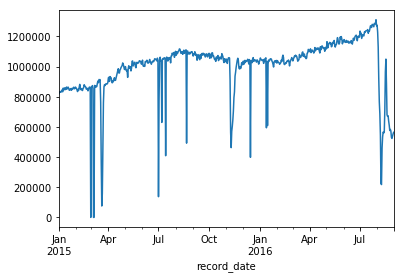

In [11]:
p1=plotuser(1416)

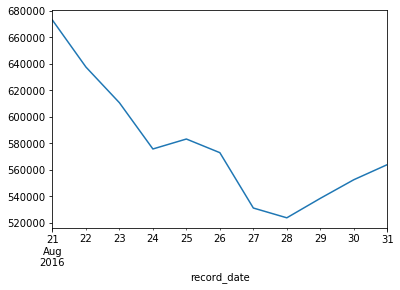

In [12]:
p1=p1[(p1.record_date>'2016-08-20') ]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

In [153]:
p1[p1.power_consumption<800000]

,record_date,user_id,power_consumption
861775,2015-02-28,1416,1
861780,2015-03-05,1416,1
861781,2015-03-06,1416,1
861793,2015-03-18,1416,763949
861794,2015-03-19,1416,369883
861795,2015-03-20,1416,75468
861796,2015-03-21,1416,157942
861797,2015-03-22,1416,468002
861798,2015-03-23,1416,760341
861898,2015-07-01,1416,137228


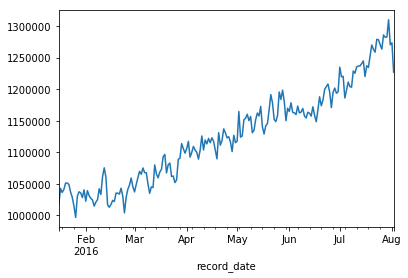

In [100]:
p1=p1[(p1.record_date<'2016-08-03') & (p1.record_date>'2016-01-15')]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

### 明显有趋势项，检验一下去掉趋势项是否平稳，稳的

In [105]:
p1.index=p1.record_date

In [108]:
ts=p1['power_consumption']

In [62]:
dta=p1.power_consumption.values
adf_test(dta,'ct')

Test Statistic                -6.215012e+00
p-value                        7.674971e-07
Lags Used                      0.000000e+00
Number of Observations Used    1.990000e+02
Critical Value (5%)           -3.432786e+00
Critical Value (1%)           -4.004998e+00
Critical Value (10%)          -3.140145e+00
dtype: float64

### 一阶差分后看图

199


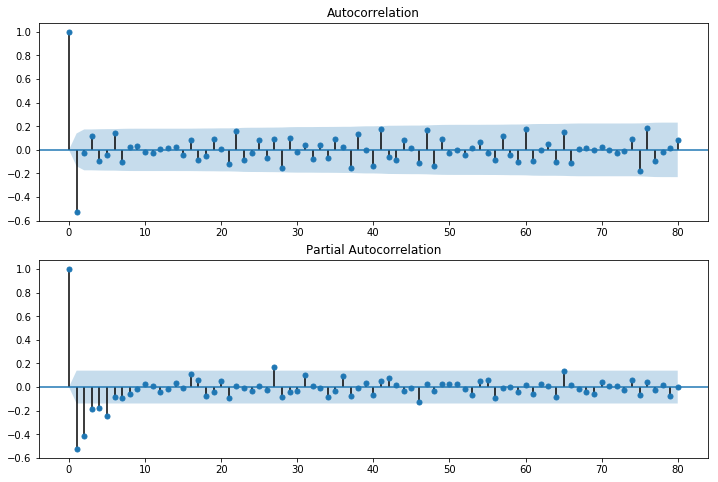

In [144]:
diff_1=p1.diff(1)
print(len(p1))
diff_1.dropna(inplace=True)
dta=diff_1.power_consumption.values
plotacfpacf(dta)

In [64]:
adf_test(dta,'c')

Test Statistic                -9.797023e+00
p-value                        6.135669e-17
Lags Used                      4.000000e+00
Number of Observations Used    1.940000e+02
Critical Value (5%)           -2.876556e+00
Critical Value (1%)           -3.464515e+00
Critical Value (10%)          -2.574775e+00
dtype: float64

In [66]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(dta,lags=1))

(array([ 8.20187982]), array([ 0.0041847]))


In [70]:
dta=dta.astype(np.float64)
arma_mod42 = sm.tsa.ARMA(dta,(4,2)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(4,3)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(3,2)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(2,2)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)
arma_mod42 = sm.tsa.ARMA(dta,(1,2)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)
arma_mod42 = sm.tsa.ARMA(dta,(4,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(3,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(2,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)
arma_mod42 = sm.tsa.ARMA(dta,(1,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)
arma_mod42 = sm.tsa.ARMA(dta,(4,0)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(3,0)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(2,0)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)
arma_mod42 = sm.tsa.ARMA(dta,(1,0)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)
arma_mod42 = sm.tsa.ARMA(dta,(0,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(0,2)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(0,3)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 
arma_mod42 = sm.tsa.ARMA(dta,(0,4)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic) 

(4396.67710359244, 4423.0235421902362, 4407.3401880945048)
(4398.383294796859, 4428.0230382193795, 4410.3792648616818)
(4396.468385686291, 4419.5215194593629, 4405.7985846255979)


D:\Anaconda3\envs\py27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4395.050893670434, 4414.8107226187803, 4403.0482070469825)
(4394.733880436562, 4411.2004045601843, 4401.3983082503519)
(4394.725317546075, 4417.7784513191464, 4404.0555164853813)
(4396.209422074, 4415.9692510223467, 4404.2067354505489)
(4394.692990045402, 4411.159514169025, 4401.3574178591925)
(4392.950242112429, 4406.1234614113273, 4398.2817843634612)
(4406.295206936083, 4426.0550358844293, 4414.2925203126315)
(4413.250824646716, 4429.7173487703385, 4419.9152524605061)
(4413.069917177101, 4426.2431364759996, 4418.4014594281334)
(4416.667651333829, 4426.5475658080022, 4420.6663080221033)
(4411.509682295911, 4421.3895967700846, 4415.5083389841857)
(4397.12220584536, 4410.2954251442588, 4402.4537480963927)
(4395.979366739167, 4412.4458908627894, 4402.6437945529569)
(4394.820213533514, 4414.5800424818608, 4402.817526910063)


In [71]:
arma_mod42 = sm.tsa.ARMA(dta,(1,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)

(4392.950242112429, 4406.1234614113273, 4398.2817843634612)


In [74]:
dta=p1.power_consumption.values
dta=dta.astype(np.float64)
arma_mod42 = sm.tsa.ARIMA(dta,(1,1,1)).fit() 
print(arma_mod42.aic,arma_mod42.bic,arma_mod42.hqic)

(4392.950238525633, 4406.1234578245312, 4398.2817807766651)


In [75]:
forecast,stderr ,conf_int =arma_mod42.forecast(30)
pd.DataFrame(forecast).to_csv('forecast1416.csv')

In [76]:
p1.to_csv('p1416.csv')

In [142]:
resid=arma_mod42.resid
print(acorr_ljungbox(resid,lags=1))

(array([ 0.04835376]), array([ 0.82595302]))


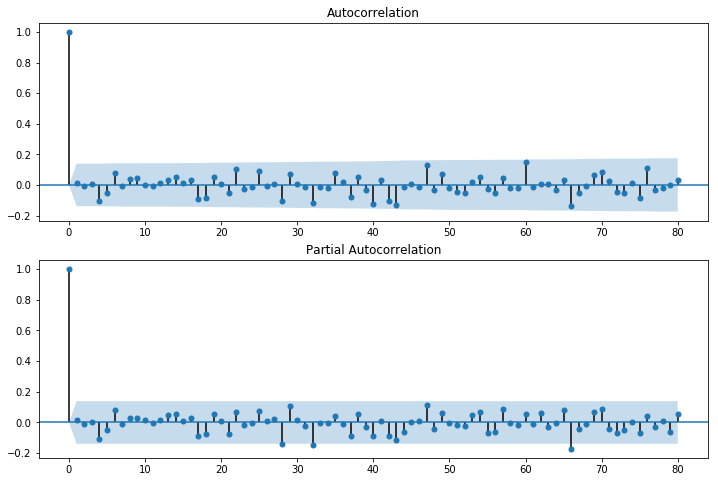

In [147]:
plotacfpacf(resid)

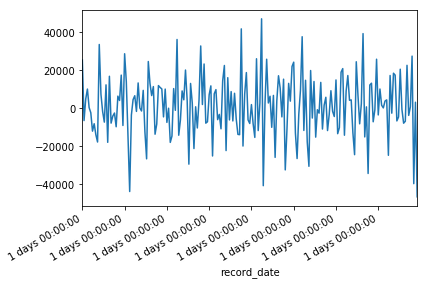

In [134]:
p1=diff_1
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

In [80]:
from sklearn.linear_model import LinearRegression 

In [93]:
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')

In [95]:
p1d=pd.DataFrame(p1s)

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts.values,freq=7)

In [136]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

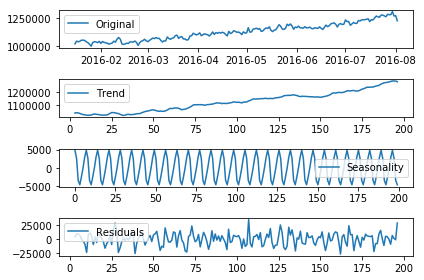

In [137]:
plt.show()

In [125]:
print(acorr_ljungbox(residual,lags=1))

(array([ 3.84677835]), array([ 0.04984164]))


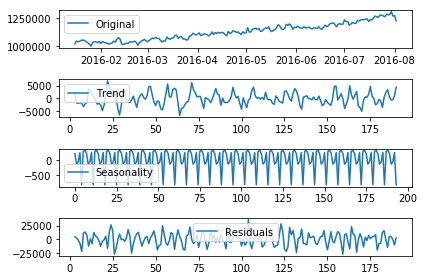

In [141]:
residual=residual[3:-3]
decomposition = seasonal_decompose(residual,freq=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [123]:
residual=residual[:-3]

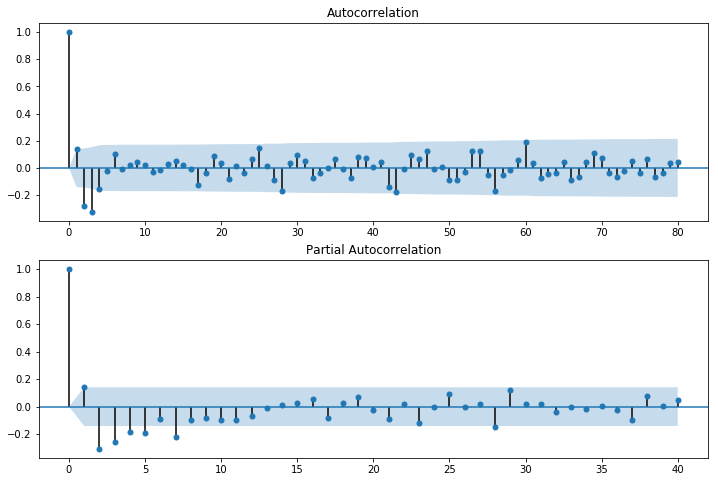

In [128]:
dta=residual
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)
plt.show()

In [129]:
adf_test(residual,'c')

Test Statistic                -7.410099e+00
p-value                        7.171718e-11
Lags Used                      1.200000e+01
Number of Observations Used    1.810000e+02
Critical Value (5%)           -2.877644e+00
Critical Value (1%)           -3.467005e+00
Critical Value (10%)          -2.575355e+00
dtype: float64

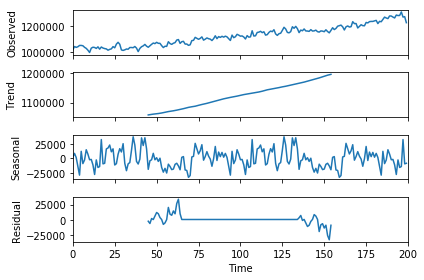

In [133]:
decompq = seasonal_decompose(ts.values,freq=90)
resplot = decompq.plot()
plt.show()

### 1416到此为止，预测值仅表明趋势值，周期波动5000，残差波动25000，没必要模拟周期

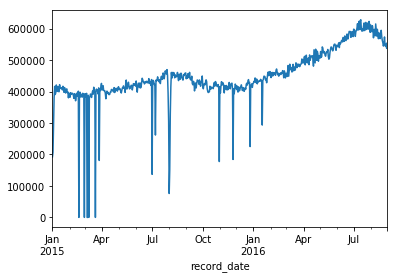

In [223]:
p1=plotuser(175)

In [225]:
p1.to_csv('p175.csv')

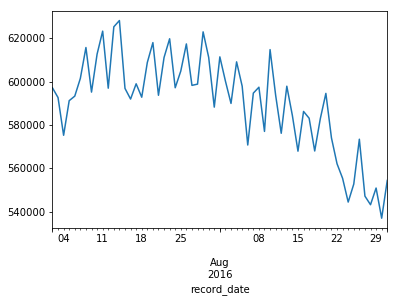

In [168]:
#p1=p1[(p1.record_date<'2016-08-03') & (p1.record_date>'2016-01-15')]
p1=p1[(p1.record_date>'2016-07-01')]
p1s=pd.Series(p1.power_consumption.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

In [190]:
y=p1.power_consumption.values
x=np.array(range(len(y)))
X= x[:, np.newaxis]


array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60]])

In [191]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
model = make_pipeline(PolynomialFeatures(2), Ridge())
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [192]:
predicty= model.predict(X)

In [221]:
x=np.array(range(len(y)+30))
x=x[len(y):]
X_pre= x[:, np.newaxis]
y_pre= model.predict(X_pre)
pd.DataFrame(y_pre).to_csv('forecast175.csv',index=False,header=False)

In [198]:
p1['res']=res

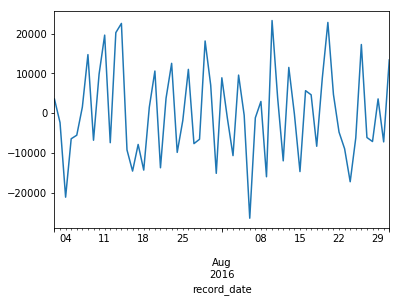

In [200]:
p1s=pd.Series(p1.res.values,index=p1.record_date,name='power_consumption')
p1s.plot()
plt.show()

In [211]:
adf_test(p1.res.values,'c')

Test Statistic                 -4.682949
p-value                         0.000091
Lags Used                       7.000000
Number of Observations Used    53.000000
Critical Value (5%)            -2.917850
Critical Value (1%)            -3.560242
Critical Value (10%)           -2.596796
dtype: float64

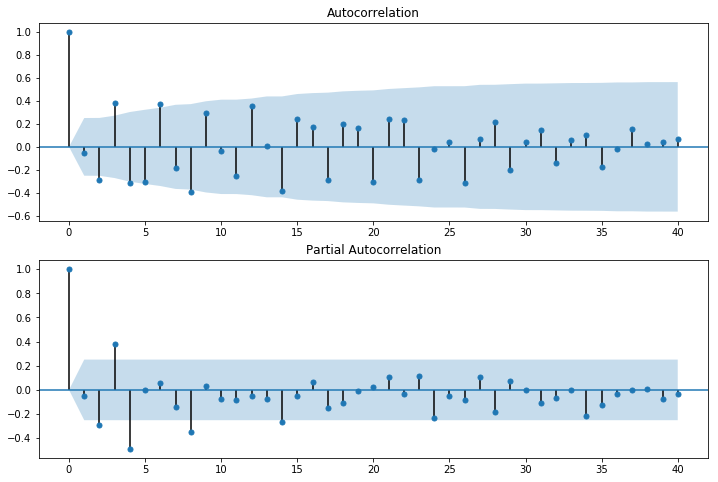

In [212]:
plotacfpacf(p1.res.values)

### 多项式拟合后，残差正负20000,残差周期正负5000，残差的残差波动20000，没必要拟合周期

### 可以看出7月份以后有个抛物线下降的趋势，且有周期性

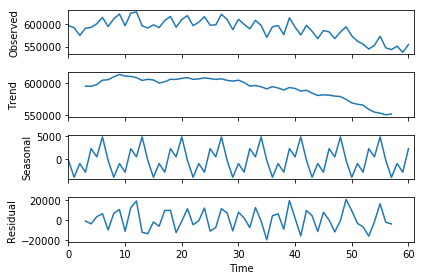

In [164]:
ts=p1.power_consumption
decompq = seasonal_decompose(ts.values,freq=7)
resplot = decompq.plot()
plt.show()

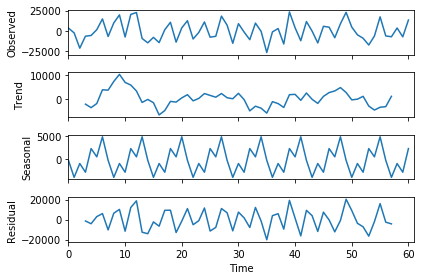

In [215]:
ts=p1.res
decompq = seasonal_decompose(ts.values,freq=7)
resplot = decompq.plot()
plt.show()